<h2><center><font color=#D40004><u>Analyzing the Results of OpenHermes-2.5-Mistral-7B: A Detailed Examination</u></font></center></h2>



<div style="padding: 40px; background: linear-gradient(135deg, #f5f7fa, #cdd2d8); border: 3px groove #d1d8e0; border-radius: 30px; box-shadow: 0 10px 25px rgba(0,0,0,0.1); font-size: 120%; line-height: 1.9; color: #333; font-family: 'Georgia', serif; text-align: justify; position: relative;">
    <h2 style="color: #2c3e50; font-size: 150%; border-bottom: 3px solid #3498db; display: inline-block; padding-bottom: 10px; margin-bottom: 20px;">
    Notebook Gool
</h2>
<p style="font-size: 140%; color: #34495e; letter-spacing: 1px;">The goal of this notebook is to analyze the output predicted by OpenHermes-2.5-Mistral-7B to identify the weaknesses of this model.</p>
</div>

# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:center; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'></span></b> <b>Table of Content</b></div>

* [I. Loading and Importing Libraries](#1)
* [II. Definition and Implementation of Metrics](#2)
  * [1. Calcul the percentage of predicted keys](#21)
  * [2. Calcul the percentage of predicted values](#23)
* [III. Clean Response Obtained by LLM](#3)
* [IV. Converting PDF to Text Preserving Original Structure](#4)
* [V. Prepare Data](#5)
* [VI. OpenHermes-2.5-Mistral-7B](#6)

<a id='1'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>I |</span></b> <b>Loading and Importing Libraries</b></div>


In [ ]:
%%capture
!pip install --upgrade pip
!pip install bitsandbytes
!pip install transformers
!pip install pdfplumber
!pip install -U sentence-transformers

In [1]:
import re
import json
from tqdm import tqdm
import pandas as pd
from datasets import load_dataset, Dataset
import pdfplumber
from wand.image import Image as WImage
import torch
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import time 
import random
import numpy as np

In [ ]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

<a id='2'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>II |</span></b> <b>Definition and Implementation of Metrics</b></div>
So, let's begin by providing an example of the expected output.

In [2]:
desired_output = {
    "GeographicContext": "Intercountry",
    "SubGeographicContext": "Intra-Western",
    "Channel": "purchase at ATM",
    "RateType": "fallback fee rates",
    "Notes":["Maestro MO/TO is permitted only for refund transactions.",
"For transactions less than or equal to EUR 25 only. Transactions greater than EUR 25 are processed under normal Maestro acceptance criteria."],
    
    "Rates": [
        {
            "PaymentProduct": "Maestro Prepaid Commercial",
            "Details": [
                {
                    "FeeTier": "Chip",
                    "IRD": ["45"],
                    "Rate": "0.40% + EUR 0.05"
                },
                {
                    "FeeTier": "Chip: Late Presentment",
                    "IRD": ["45"],
                    "Rate": "0.75% + EUR 0.05"
                },
                {
                    "FeeTier": "PIN Verified",
                    "IRD": ["46"],
                    "Rate": "0.50% + EUR 0.05"
                },
                {
                    "FeeTier": "Signature Verified",
                    "IRD": ["47"],
                    "Rate": "0.75% + EUR 0.05"
                },
                {
                    "FeeTier": "Masterpass Wallet",
                    "IRD": ["PW"],
                    "Rate": "1.50%"
                },
                {
                    "FeeTier": "Secure E-commerce",
                    "IRD": ["48"],
                    "Rate": "1.05% + EUR 0.05"
                },
                {
                    "FeeTier": "Mail Order/Telephone Order",
                    "IRD": ["MO"],
                    "Rate": "1.05% + EUR 0.05"
                },
                {
                    "FeeTier": "Contactless",
                    "IRD": ["P1"],
                    "Rate": "0.40% + EUR 0.05"
                }
            ]
        },
        {
            "PaymentProduct": "Maestro",
            "Details": [
                {
                    "FeeTier": "Purchase part of the Purchase with Cash Back transaction",
                    "IRD": [],
                    "Rate": "Depending on tier claimed POS interchange rate relevant to the applicable tier. Refer to Intra-EEA Maestro POS Fallback Interchange Fee Rates."
                },
                {
                    "FeeTier": "Cash back part of the Purchase with Cash Back transaction",
                    "IRD": ["N/A"],
                    "Rate": "0.00"
                }
            ]
        }
    ]
}


To compare between the expected JSON and the predicted JSON, we first need to verify the percentage of predicted keys relative to the desired keys

<a id='21'></a>
>##  Calcul the percentage of predicted keys

Let's begin by defining a function to retrieve all keys from a dictionary.

In [3]:
def get_keys(d):
    # Iterate over each key-value pair in the dictionary
    for k, v in d.items():
        # Append the key to the list of all_keys
        all_keys.append(k)
        # If the value is a dictionary, recursively call get_keys
        if isinstance(v, dict):
            get_keys(v)
        # If the value is a list, iterate over each item
        elif isinstance(v, list):
            for item in v:
                # If the item is a dictionary, recursively call get_keys
                if isinstance(item, dict):
                    get_keys(item)
# Define a function to retrieve all unique keys from a nested dictionary
def get_all_keys(d):
    # Declare all_keys as a global variable
    global all_keys
    # Initialize all_keys as an empty list
    all_keys = []
    # Call the helper function get_keys to populate all_keys
    get_keys(d)
    # Return a list containing the unique keys by converting all_keys to a set and then back to a list
    return list(set(all_keys))

In [4]:
# Testing our function
get_all_keys(desired_output)

['Notes',
 'PaymentProduct',
 'GeographicContext',
 'RateType',
 'Channel',
 'FeeTier',
 'IRD',
 'Rate',
 'Details',
 'SubGeographicContext',
 'Rates']

Now, in comparison to strings, we will begin by removing spaces and converting all characters to lowercase

In [5]:
def process_dict(data):
    if isinstance(data, dict):
        for key, value in data.items():
            if isinstance(value, str):
                data[key] = value.strip().lower()
            elif isinstance(value, list):
                data[key] = [process_dict(item) for item in value]
            elif isinstance(value, dict):
                data[key] = process_dict(value)
    return data

In [6]:
# Example usage
sample_dict = {
    "name": "John",
    "age": 30,
    "city": "New York",
    "friends": [
        {
            "name": "Alice",
            "age": 28
        },
        {
            "name": "Bob",
            "age": 32
        }
    ],
    "hobbies": ["reading", "traveling", "cooking"]
}

processed_dict = process_dict(sample_dict)
processed_dict

{'name': 'john',
 'age': 30,
 'city': 'new york',
 'friends': [{'name': 'alice', 'age': 28}, {'name': 'bob', 'age': 32}],
 'hobbies': ['reading', 'traveling', 'cooking']}

Now, we define the percentage of predicted keys as follows:

$$\Large \text{Percentage of predicted keys} = \frac{\text{Number of correctly predicted keys}}{\text{Total number of true keys}}$$


In [7]:
def Percentage_of_predicted_keys(true_dic, pred_dic):
    true_dic = process_dict(true_dic)
    pred_dic = process_dict(pred_dic)
    # Get all keys of the true dictionary
    all_keys_of_true_dic = get_all_keys(true_dic)
    # Get all keys of the predicted dictionary
    all_keys_of_pred_dic = get_all_keys(pred_dic)
    
    # Check if there are no keys in the true dictionary to avoid division by zero
    if len(all_keys_of_true_dic) == 0:
        return 0  # Avoid division by zero
    
    # Initialize count of predicted keys
    p_keys = 0
    # Iterate through all keys in the predicted dictionary
    for key in all_keys_of_pred_dic:
        # Check if the key is also present in the true dictionary
        if key in all_keys_of_true_dic:
            # Increment count if the key is found in both dictionaries
            p_keys += 1
    
    # Calculate the percentage of predicted keys compared to true keys
    p_keys /= len(all_keys_of_true_dic)
    # Return the percentage of predicted keys
    return p_keys

In [8]:
# Define a true dictionary
true_dict = {
    "name": "John",
    "age": 30,
    "city": "New York"
}

# Define a predicted dictionary with some correct and some incorrect keys
pred_dict = {
    "name": "John",
    "age": 30,
    "country": "USA"
}

# Calculate the percentage of predicted keys
percentage = Percentage_of_predicted_keys(true_dict, pred_dict)

# Print the result
print("Percentage of predicted keys:", percentage)

Percentage of predicted keys: 0.6666666666666666


Now we will define the principal metrics used to compare the values of two JSON objects.

<a id='23'></a>

>## Calculate the percentage of predicted value

The function calculates the percentage of correctly predicted values compared to the total number of true values across different types of data structures.

The formula for calculating the percentage of values is as follows:

$$
\text{Percentage of values} = \frac{\sum_{i=1}^{\text{Total number of predicted keys}} p_i \cdot w_i}{\sum_{i=1}^{\text{Total number of true keys}} w_i}
$$

Here, $p_i$ represents the percentage of correctly predicted values for each key. It's calculated as:

$$p_i = \frac{\text{Number of correctly predicted values of item i}}{\text{Total number of true values of item i}}$$

and $ w_i$ is the total number of true values of item i.

In [9]:
# Define a function to count the values in a nested dictionary. This function assists in calculating weights.
def count_values_in_dic(d):
    # Initialize a counter
    count = 0
    
    # Check if d is a string
    if isinstance(d, (str,int,float)):
        # Increment the counter
        count += 1
        
    # Check if d is a list containing only strings
    if isinstance(d, list) and all(isinstance(item, (str,int,float)) for item in d):
        # Add the length of the list to the counter
        count += len(d)
        
    # Check if d is a list containing only dictionaries
    if isinstance(d, list) and all(isinstance(item, dict) for item in d):
        # Iterate through each item in the list
        for item in d:
            # Recursively call count_values_in_dic for each item in the list
            count += count_values_in_dic(item)
  
    # Check if d is a dictionary
    if isinstance(d, dict):
        # Traverse through the dictionary items
        for key, value in d.items():
            # If the value is a string, increment the counter
            if isinstance(value, (str,int,float)):
                count += 1
            
            # If the value is a dictionary, count its values recursively
            elif isinstance(value, dict):
                count += count_values_in_dic(value)
                    
            # If the value is a list, count the values in the list      
            elif isinstance(value, list):
                # Iterate through each element in the list
                for item in value:
                    # If the element is a dictionary, count its values
                    if isinstance(item, dict):
                        count += count_values_in_dic(item)
                    # If the element is a string, increment the counter
                    elif isinstance(item, (str,int,float)):
                        count += 1

    # Return the total count
    return count

In [10]:
# Define a sample nested dictionary
sample_dict = {
    "name": "John",
    "age": 30,
    "city": "New York",
    "friends": [
        {
            "name": "Alice",
            "age": 28
        },
        {
            "name": "Bob",
            "age": 32
        }
    ],
    "hobbies": ["reading", "traveling", "cooking"]
}

# Count the values in the dictionary
values_count = count_values_in_dic(sample_dict)

# Print the result
print("Number of values in the dictionary:", values_count)

Number of values in the dictionary: 10


In [11]:
def calculate_percentage_of_values(true_dic, pred_dic):
    
    true_dic = process_dict(true_dic)
    pred_dic = process_dict(pred_dic)
    
    total_percentage = 0  # Initialize total percentage
    sum_of_w_i = 0 # Initialize sum of weights
    
    # Type 1: Single string values
    for key, true_value in true_dic.items():  # Loop through key-value pairs in true_dic
        if isinstance(true_value, str):  # Check if the value is a string
            w_i = 1 # Weight for this item
            sum_of_w_i += w_i  # Add weight to the sum of weights
            # Check if the key exists in pred_dic, if its value is a string and if it matches the true value
            if key in pred_dic and isinstance(pred_dic[key], str) and pred_dic[key] == true_value:
                match = 1  # Assign perfect match
            else:
                match = 0  # Assign no match
            total_percentage += match*w_i  # Add the match value to the total percentage
            
    # Type 2: Lists of strings
    for key, true_value in true_dic.items():  # Loop through key-value pairs in true_dic
        if isinstance(true_value, list) and all(isinstance(item, str) for item in true_value):
            # Check if the value is a list of strings
            w_i = len(true_value) # Weight for this item
            sum_of_w_i += w_i  # Add weight to the sum of weights
            total_number_of_true_values = len(true_value)  # Get the total number of true values
            
            if key in pred_dic and isinstance(pred_dic[key], list):
                # Check if the key exists in pred_dic and its value is a list
                correct_pred_values = sum(1 for v in pred_dic[key] if v in true_value)  # Count correct predictions
            else:
                correct_pred_values = 0  # No correct predictions if the key doesn't exist or its value is not a list
            if total_number_of_true_values:
                percentage_correct = correct_pred_values / total_number_of_true_values  # Calculate percentage of correct predictions
            else:
                percentage_correct = 0  # If there are no true values, assign 0
            total_percentage += percentage_correct*w_i  # Add the percentage to the total percentage
    
    # Type 4: dictionarie
    for key, true_value in true_dic.items():  # Loop through key-value pairs in true_dic
        if isinstance(true_value, dict)  :
            w_i = count_values_in_dic(true_value) # Weight for this item
            sum_of_w_i += w_i # Add weight to the sum of weights
            
            if key in pred_dic and isinstance(pred_dic[key], dict):
                percentage_correct = calculate_percentage_of_values(true_value, pred_dic[key])
            else:
                percentage_correct = 0
            total_percentage += percentage_correct*w_i
    # Type 5: Lists of dictionaries
    for key, true_value in true_dic.items():  # Loop through key-value pairs in true_dic
        if isinstance(true_value, list) and all(isinstance(item, dict) for item in true_value):
            # Check if the value is a list of dictionaries
            w_i = count_values_in_dic(true_value) # Weight for this item
            sum_of_w_i += w_i # Add weight to the sum of weights
            sub_total_percentage = 0  # Initialize subtotal percentage
            
            for dict_item in true_value:  # Loop through each dictionary in the list
                max_similarity = 0  # Initialize max similarity score
                most_similar_pred_item = None  # Initialize most similar predicted item
                pred_items = pred_dic.get(key, [])  # Get predicted items for the current key
                #print(dict_item)
                for pred_item in pred_items:  # Loop through each prediction for the current key
                    
                    similarity = calculate_percentage_of_values(dict_item, pred_item)  # Calculate similarity

                    if similarity > max_similarity:
                        max_similarity = similarity
                        most_similar_pred_item = pred_item
                    if max_similarity==1:
                        break
                if most_similar_pred_item is not None:
                    pred_items.remove(most_similar_pred_item)  # Remove the most similar predicted item from the list
                sub_total_percentage += max_similarity  # Add max similarity to subtotal
                
            if len(true_value) > 0:
                average_similarity = sub_total_percentage / len(true_value)  # Calculate average similarity
            else:
                average_similarity = 0  # If there are no dictionaries, assign 0
            total_percentage += average_similarity* w_i  # Add the percentage to the total percentage
    #print(total_percentage , sum_of_w_i)
    return total_percentage / sum_of_w_i  # Calculate and return the average percentage

In [12]:
true_dict = {
    'a': 'hello',
    'b': ['world', 'foo', 'bar'],
    'c': [{'x': 'apple'}, {'y': 'banana'}, {'z': 'orange'}],
    'd': {
        'e': 'python',
        'f': ['java', 'javascript'],
        'g': [{'h': 'ruby'}, {'i': 'php'}]
    }
}

pred_dict = {
    'a': 'Hey',
    'b': ['world', 'foo', 'bar'],
    'c': [{'x': 'apple'}, {'y': 'banana'}, {'z': 'orange'}],
    'd': {
        'e': 'python',
        'f': ['java', 'javascript'],
        'g': [{'h': 'ruby'}, {'i': 'php'}]
    }
}

# Calculate the percentage of predicted values
percentage = calculate_percentage_of_values(true_dict, pred_dict)

# Print the result
print("Percentage of predicted values:", percentage)

Percentage of predicted values: 0.9166666666666666


<a id='3'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>III |</span></b> <b>Clean Response Obtained by LLM</b></div>

Our goal is to obtain a response from LLM in JSON format. However, LLMs sometimes provide additional explanatory sentences along with the JSON data. Therefore, we need to define a function to extract only the JSON data from the response.

Here example of our issue:
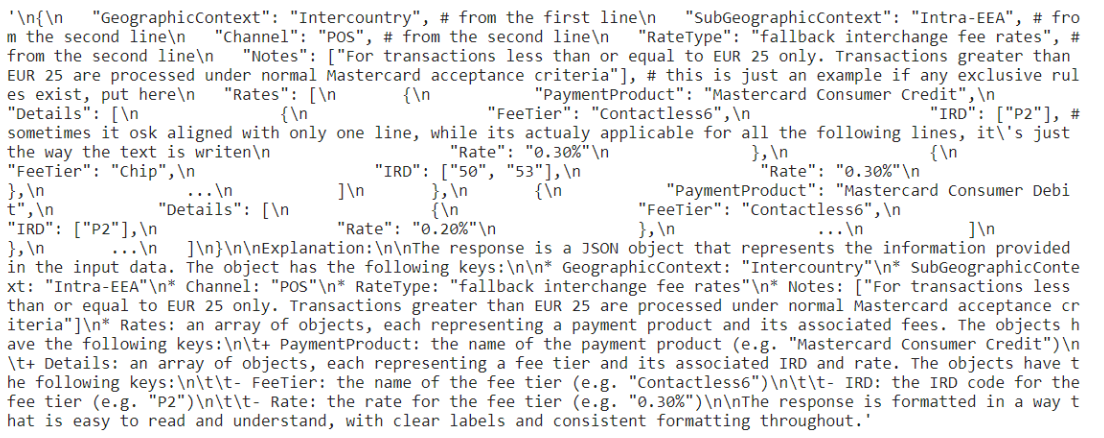

In [13]:
def clean_and_load_json(s):
    # Remove comments
    s = re.sub(r'//.*?\n', '', s)
    s = re.sub(r'#.*?\n', '', s)
    # Remove trailing commas before closing brackets in lists and dictionaries
    s = re.sub(r',\s*\n\s*(\]|\})', r'\1', s)
    # Remove patterns like '\n       ...\n'
    s = re.sub(r'\n\s*\.\.\.\n', '', s)
    # Remove comma before } or ]
    s = re.sub(r',\s*(\]|\})', r'\1', s)
    # Remove unnecessary whitespace
    s = s.strip()
    #print(s)
    # Load the cleaned JSON string
    return json.loads(s)

In [14]:
def parse_json(s):
    try:
        json_str = json.loads(s)
    except:
        # Find the index of the first occurrence of '{\n'
        start_idx = s.find('{')

        # Find the index of the last occurrence of '\n}'
        end_idx = s.rfind('}')

        # If either index is not found, raise an error
        if start_idx == -1 or end_idx == -1:
            raise ValueError("Could not find JSON object in the provided string.")

        # Extract the JSON substring from start_idx to end_idx (inclusive) + 3 to include the closing '\n}'
        json_str = s[start_idx:end_idx+1]
        try:
             json_str = json.loads(json_str)
        except:
            json_str =  clean_and_load_json(json_str)
    return json_str

In [15]:
# test our function in last example 
st = '\n{\n   "GeographicContext": "Intercountry", # from the first line\n   "SubGeographicContext": "Intra-EEA", # from the second line\n   "Channel": "POS", # from the second line\n   "RateType": "fallback interchange fee rates", # from the second line\n   "Notes": ["For transactions less than or equal to EUR 25 only. Transactions greater than EUR 25 are processed under normal Mastercard acceptance criteria"], # this is just an example if any exclusive rules exist, put here\n   "Rates": [\n       {\n           "PaymentProduct": "Mastercard Consumer Credit",\n           "Details": [\n               {\n                   "FeeTier": "Contactless6",\n                   "IRD": ["P2"], # sometimes it osk aligned with only one line, while its actualy applicable for all the following lines, it\'s just the way the text is writen\n                   "Rate": "0.30%"\n               },\n               {\n                   "FeeTier": "Chip",\n                   "IRD": ["50", "53"],\n                   "Rate": "0.30%"\n               },]\n       },\n       {\n           "PaymentProduct": "Mastercard Consumer Debit",\n           "Details": [\n               {\n                   "FeeTier": "Contactless6",\n                   "IRD": ["P2"],\n                   "Rate": "0.20%"\n               },\n               ...\n   ]\n       },\n       ...\n   ]\n}\n\nExplanation:\n\nThe response is a JSON object that represents the information provided in the input data. The object has the following keys:\n\n* GeographicContext: "Intercountry"\n* SubGeographicContext: "Intra-EEA"\n* Channel: "POS"\n* RateType: "fallback interchange fee rates"\n* Notes: ["For transactions less than or equal to EUR 25 only. Transactions greater than EUR 25 are processed under normal Mastercard acceptance criteria"]\n* Rates: an array of objects, each representing a payment product and its associated fees. The objects have the following keys:\n\t+ PaymentProduct: the name of the payment product (e.g. "Mastercard Consumer Credit")\n\t+ Details: an array of objects, each representing a fee tier and its associated IRD and rate. The objects have the following keys:\n\t\t- FeeTier: the name of the fee tier (e.g. "Contactless6")\n\t\t- IRD: the IRD code for the fee tier (e.g. "P2")\n\t\t- Rate: the rate for the fee tier (e.g. "0.30%")\n\nThe response is formatted in a way that is easy to read and understand, with clear labels and consistent formatting throughout.'

# Extract JSON
parsed_json = parse_json(st)

# Print the result
parsed_json

{'GeographicContext': 'Intercountry',
 'SubGeographicContext': 'Intra-EEA',
 'Channel': 'POS',
 'RateType': 'fallback interchange fee rates',
 'Notes': ['For transactions less than or equal to EUR 25 only. Transactions greater than EUR 25 are processed under normal Mastercard acceptance criteria'],
 'Rates': [{'PaymentProduct': 'Mastercard Consumer Credit',
   'Details': [{'FeeTier': 'Contactless6', 'IRD': ['P2'], 'Rate': '0.30%'},
    {'FeeTier': 'Chip', 'IRD': ['50', '53'], 'Rate': '0.30%'}]},
  {'PaymentProduct': 'Mastercard Consumer Debit',
   'Details': [{'FeeTier': 'Contactless6', 'IRD': ['P2'], 'Rate': '0.20%'}]}]}

<a id='4'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>IV |</span></b> <b>Converting PDF to Text Preserving Original Structure</b></div>

In [16]:
def extract_text_from_pdf(pdf_path):
    docs=[]
    with pdfplumber.open(pdf_path) as pdf:
        for page_number, page in enumerate(pdf.pages, start=1):
            # Try to extract the text
            text= page.extract_text(x_tolerance=2, y_tolerance=4, layout=True, x_density=5, y_density=10)
            docs.append({'page_num':page_number, 'text':text})
           
    return docs

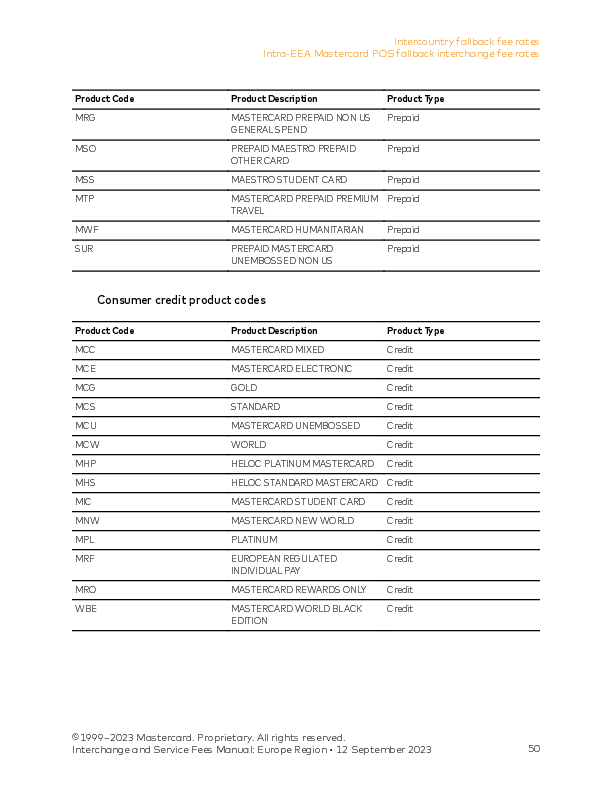

In [17]:
# Display the first page of our PDF
path = '/kaggle/input/somepages/mc_EuropeInterchangeManual_Customer-50-52.pdf'
img = WImage(filename=path)
img

In [18]:
# Convert PDF to text
docs = extract_text_from_pdf(path)

# Print the text of the first page to compare the structure between the converted and original
print(docs[0]['text'])

                                                                                                                          
                                                                                                                          
                                                                                                                          
                                                                                                                          
                                                                               Intercountry fallback fee rates            
                                                     Intra-EEA Mastercard POS  fallback interchange fee rates             
                                                                                                                          
                                                                                                                          
                

<a id='5'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>V |</span></b> <b>Data Preparation</b></div>
<p>Next, we will prepare a dataset consisting of context and correct responses. To compile this dataset, we've extracted 59 pages from our PDF and supplied them to Gemini. We've asked Gemini to furnish responses in JSON format. Following this, we've validated the results received from Gemini.</p>


In [19]:
with open("/kaggle/input/mc-eurpen/mc_EuropeInterchangeManual_Customer (2).txt", 'r', encoding='utf-8') as file:
    content = file.read()

token = 'Interchange and  Service Fees Manual: Europe Region • 12 September  2023'
paginated_doc = content.split(token)

In [20]:
data = []
i=40
with open("/kaggle/input/clean-data-for-fine-t/clean_data.jsonl",encoding='utf-8') as file:
    for line in file:
        response = json.loads(line)
        
        if response =={"message": "Context lacks a Payment product"}:
            response={'message': 'Context lacks a Payment product,FeeTier and Rate'}
        context = paginated_doc[i]
        data.append({"context":context,"response":response})
        i+=1

In [21]:
df = pd.DataFrame(data)
df.shape

(59, 2)

In [22]:
print(df.loc[0,'context'])

                    41              
                                                                                                                          
                                                                                                                                                                                                                                                    
                                                                                                                          
                                                                                                                          
                                                                                                                          
                                                                                       Global program  rates              
                                                                                                       

In [23]:
print(df.loc[0,'response'])

{'message': 'Context lacks a Payment product,FeeTier and Rate'}


In [24]:
print(df.loc[15,'context'])

                    56              
                                                                                                                          
                                                                                                                                                                                                                                                    
                                                                                                                          
                                                                                                                          
                                                                                                                          
                                                                               Intercountry fallback fee rates            
                               Intra-EEA Mastercard  MoneySend   funding transaction fallback service f

In [25]:
print(df.loc[15,'response'])

{'GeographicContext': 'Intercountry', 'SubGeographicContext': 'Intra-EEA', 'Channel': 'Mastercard MoneySend funding transaction', 'RateType': 'fallback service fee rates', 'Notes': [], 'Rates': [{'PaymentProduct': 'Mastercard BusinessCard/Mastercard Professional Card/Mastercard Executive BusinessCard/Mastercard Corporate Executive Card\nMastercard Electronic BusinessCard\nDebit Mastercard for Business', 'Details': [{'FeeTier': 'N/A', 'IRD': ['Q6', 'Q7'], 'Rate': '1.65%'}]}, {'PaymentProduct': 'Mastercard Purchasing', 'Details': [{'FeeTier': 'N/A', 'IRD': ['Q6', 'Q7'], 'Rate': '1.65%'}]}, {'PaymentProduct': 'Mastercard Fleetcard', 'Details': [{'FeeTier': 'N/A', 'IRD': ['Q6', 'Q7'], 'Rate': '1.65%'}]}, {'PaymentProduct': 'Mastercard Prepaid\nCommercial', 'Details': [{'FeeTier': 'N/A', 'IRD': ['Q6', 'Q7'], 'Rate': '1.65%'}]}]}


<a id='6'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>VI |</span></b> <b>OpenHermes-2.5-Mistral-7B</b></div>


The initial step involves defining an accuracy function to calculate the percentage of predicted values and keys

In [26]:
def accuracy(df):
    df['clean_pred_response'] = df['pred_response'].map(parse_json)
    
    average_percentage_of_predicted_keys = 0
    average_percentage_of_predicted_values = 0
    
    for i in df.index:
        true_dic = df.loc[i,'response']
        pred_dic = df.loc[i,'clean_pred_response']
        if type(pred_dic)==list:
            pred_dic = pred_dic[0]
        average_percentage_of_predicted_keys += Percentage_of_predicted_keys(true_dic, pred_dic)
        average_percentage_of_predicted_values += calculate_percentage_of_values(true_dic, pred_dic)

    average_percentage_of_predicted_keys /= df.shape[0]
    average_percentage_of_predicted_values /= df.shape[0]
    
    return average_percentage_of_predicted_keys,average_percentage_of_predicted_values

In [27]:
 prompt = """
 Answer the question based on the context below.
 If the INPUTDATA is missing a "Payment product", respond with the following JSON:
{"message": "Context lacks a Payment product,FeeTier and Rate"}
Otherwise, please fill in the provided information from INPUTDATA to match the format below. Any elements prefixed by <var> are variables used for explanatory purposes. If a value is not found, please leave it empty. Note that the data in this template are for reference only; do not use them. If a value is not found, leave it empty.

{
    "GeographicContext": <var>"Intercountry", # extracted from the first line
    "SubGeographicContext": <var>"Intra-EEA", # extracted from the second line
    "Channel": <var>"Mastercard POS", # extracted from the second line
    "RateType": <var>"fallback interchange fee rates", # extracted from the second line
    "Notes": <var>["For transactions less than or equal to EUR 25 only. Transactions greater than EUR 25 are processed under normal Mastercard acceptance criteria"], # example of any exclusive rules; put here if applicable you can found in last lines in context

    "Rates": [
        {
            "Payment Product": <var>"Mastercard Consumer Credit", # you found exactly Payment Product sinon n'exist pas
            "Details": [
                {
                    "Fee Tier": <var>"Contactless 6", # 
                    "IRD": <var>["P2"], # can be aligned with only one line, applicable for all following lines
                    "Rate": <var>"0.30%" # you get exactly name Rate or Fee rate in context else n'exist pas
                },
                {
                    "Fee Tier": <var>"Chip",
                    "IRD": <var>["50", "53"], # 
                    "Rate": <var>"0.30%"  # you get exactly name Rate or Fee rate in context else n'exist pas
                },
                ...
            ]
        },
        {
            "PaymentProduct": <var>"Mastercard Consumer Debit",
            "Details": [
                {
                    "FeeTier": <var>"Contactless 6",
                    "IRD": <var>["P2"],
                    "Rate": <var>"0.20%"
                },
                ...
            ]
        },
        ...
    ]
}
"""

Next, we will load a model

In [28]:
base_model_id = "teknium/OpenHermes-2.5-Mistral-7B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("teknium/OpenHermes-2.5-Mistral-7B")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Now, we define a function predcition qui take context as input and return response gets by our model

In [29]:
def prediction(context):
    template = f"Instruction:\n{prompt}\nINPUTDATA:{context}\nResponse:\n"
    messages = [
        {"role": "user", "content": template}
    ]

    input_ids = tokenizer.apply_chat_template(conversation=messages, tokenize=True, add_generation_prompt=True, return_tensors='pt').to('cuda')
    
    model.eval()
    with torch.no_grad():
        output_ids = model.generate(input_ids,max_new_tokens=3000,do_sample=True,temperature=0.000000005,top_k=100,penalty_alpha=0.2,epsilon_cutoff=3e-4,eta_cutoff=3e-4,use_cache=True)
        response = tokenizer.decode(output_ids[0][input_ids.shape[1]:], skip_special_tokens=True) 
    return response

In this step, we analyze each example in our dataset one by one. That is, we ask the model to predict a response for each example, and then we calculate the accuracy to determine if there are specific cases where our model does not provide accurate results. 

In [30]:
# Create a copy of the DataFrame
df_copy = df.copy()
df_copy['pred_response'] = None

# Iterate through each row in the DataFrame with tqdm for progress visualization
for i in tqdm(df_copy.index, desc="Generating Predictions", total=len(df_copy)):
    
    context = df_copy.loc[i,'context']
    res = prediction(context)
    # Update the 'pred_response' column with the generated prediction
    df_copy.loc[i,'pred_response'] = res

Generating Predictions:   0%|          | 0/59 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
2024-03-27 10:00:07.943320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 10:00:07.943424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 10:00:08.111828: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Generating Predictions:   2%|▏         | 1/59 [00:27

In [41]:
sum_percentage_of_predicted_keys = 0
sum_percentage_of_predicted_values = 0

for i in df.index:
    print("ID: ",i)
    pred_dict = parse_json(df_copy.loc[i,'pred_response'])
    true_dict = df_copy.loc[i,'response']
    print("-------"*7+"prediction"+"-------"*7)
    print(json.dumps(pred_dict, indent=2))
    print('\n')
    print("-------"*7+"expected"+"-------"*7)
    print(json.dumps(true_dict, indent=2))
    p_p_k = Percentage_of_predicted_keys(true_dict, pred_dict)
    p_p_v = calculate_percentage_of_values(true_dict, pred_dict)
    print("\n"+"-------"*7+"accuracy"+"-------"*7)
    print("keys(%)",p_p_k)
    print("values(%)",p_p_v)
    sum_percentage_of_predicted_keys += p_p_k
    sum_percentage_of_predicted_values += p_p_v

ID:  0
-------------------------------------------------prediction-------------------------------------------------
{
  "message": "Context lacks a Payment product,FeeTier and Rate"
}


-------------------------------------------------expected-------------------------------------------------
{
  "message": "context lacks a payment product,feetier and rate"
}

-------------------------------------------------accuracy-------------------------------------------------
keys(%) 1.0
values(%) 1.0
ID:  1
-------------------------------------------------prediction-------------------------------------------------
{
  "message": "Context lacks a Payment product,FeeTier and Rate"
}


-------------------------------------------------expected-------------------------------------------------
{
  "message": "context lacks a payment product,feetier and rate"
}

-------------------------------------------------accuracy-------------------------------------------------
keys(%) 1.0
values(%) 1.0
ID:  2
---

In [42]:
average_percentage_of_predicted_keys = sum_percentage_of_predicted_keys/len(df)
average_percentage_of_predicted_values = sum_percentage_of_predicted_values/len(df)

print("Average Percentage of Predicted Keys:", average_percentage_of_predicted_keys)
print("Average Percentage of Predicted values:", average_percentage_of_predicted_values)

Average Percentage of Predicted Keys: 0.6271186440677966
Average Percentage of Predicted values: 0.3212584900332462


## Overall Accuracy:
The accuracy of predictions varies greatly. While some predictions achieve 100% accuracy for both keys and values, others have 0% accuracy.

## Specific Observations:

### Accurate Identification of Missing Information:
Our model correctly identified 12 out of 16 pages that lacked the desired information (Payment product, FeeTier, and Rate). This indicates its effectiveness in recognizing the contexts without product payment.

### Varying Accuracy in Predicting Specific Details:
The model successfully predicted information on 21 out of 42 pages with an accuracy ranging from 5% to 66%. This suggests that while the model can identify the presence of information, its precision in predicting specific details within complex contexts requires further improvement.

### False Negatives:
In 18 instances, the model incorrectly predicted that pages lacked the desired information when they actually contained it. This indicates a need to refine the model to reduce false negatives.

### False Positives:
The model incorrectly predicted that 3 pages contained the desired information when they were actually missing it. This highlights the importance of addressing false positives to ensure reliable information extraction.
